In [20]:
#5分类

In [7]:
pip install torch -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple


The following command must be run outside of the IPython shell:

    $ pip install torch -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [8]:
pip install torchvision -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple


The following command must be run outside of the IPython shell:

    $ pip install torchvision -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [9]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [10]:
import os
from PIL import Image

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
#from torchvision.models.mobilenetv2 import Conv2dNormActivation

# 定义类别标签和对应的索引
label_dict = {
    "cats": 0,
    "dogs": 1,
    "ELEPHANT": 2,
    "HORSE": 3,
    "LION": 4
}
# 定义索引和对应的类别名称
class_dict = {
    0: "cats",
    1: "dogs",
    2: "ELEPHANT",
    3: "HORSE",
    4: "LION"
}
N = 5  # 更新类别数量为5，因为有五个类别

# 其他代码保持不变，但是确保在数据加载和模型定义中使用更新后的类别数量和标签字典
class MyDataset(Dataset):
    def __init__(self, _data_dir, _transform, _loader):
        self.labels = [_label for _label in os.listdir(_data_dir)]
        _file_path_label_list = [(os.path.join(_data_dir, _label, _img_fn), _label)
                                 for _label in os.listdir(_data_dir)
                                 for _img_fn in os.listdir(os.path.join(_data_dir, _label))
                                 if not os.path.isdir(os.path.join(_data_dir, _label, _img_fn))]

        self.data = [(_loader(_fp), label_dict[_label]) for _fp, _label in _file_path_label_list]
        self.transform = _transform

    def __getitem__(self, item):
        _img, _label = self.data[item]
        _img = self.transform(_img)
        return _img, _label

    def __len__(self):
        return len(self.data)


def load_data():
    print('data processing...')
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
    ])
    data_dir = "data/training_data/"
    train_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))
    test_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))

    train_size = int(len(train_dataset) * 0.8)
    validate_size = len(train_dataset) - train_size
    train, val = torch.utils.data.random_split(train_dataset, [train_size, validate_size])

    train_data_loader = DataLoader(dataset=train, batch_size=50, shuffle=True, num_workers=0)
    val_data_loader = DataLoader(dataset=val, batch_size=50, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=0)

    return train_data_loader, val_data_loader, test_data_loader




In [11]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from classify.data_process import load_data
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from classify.decorator import metric_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(20)

class cnn(nn.Module):
    def __init__(self, in_channels=3):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=16,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Linear(3 * 3 * 64, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.out = nn.Linear(10, N)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.out(x))
        x = F.log_softmax(x, dim=1)
        return x


def get_val_loss(model, Val):
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    val_loss = []
    for (data, target) in Val:
        data, target = data.to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss.append(loss.cpu().item())

    return np.mean(val_loss)


@metric_time
def train():
    writer = SummaryWriter("log/")
    train_data_loader, val_data_loader, _ = load_data()
    print('train...')
    epoch_num = 30
    best_model = None
    min_epochs = 5
    min_val_loss = 5
    model = cnn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in tqdm(range(epoch_num), ascii=True):
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.long().to(device)
            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
        # validation
        val_loss = get_val_loss(model, val_data_loader)
        writer.add_scalar("val_loss", val_loss, epoch)
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        tqdm.write('Epoch {:03d} train_loss {:.5f} val_loss {:.5f}'.format(epoch, np.mean(train_loss), val_loss))

    torch.save(best_model.state_dict(), "model/cnn.pkl")


@metric_time
def test():
    _, _, test_dataset = load_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cnn().to(device)
    model.load_state_dict(torch.load("model/cnn.pkl"), False)
    total = 0
    current = 0
    model.eval()
    for (data, target) in test_dataset:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        predicted = torch.max(outputs.data, 1)[1].data
        total += target.size(0)
        current += (predicted == target).sum()

    print('Accuracy:%d%%' % (100 * current / total))

In [12]:
train()

data processing...
train...


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\ana\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 000 train_loss 1.49289 val_loss 1.36181


Epoch 001 train_loss 1.27705 val_loss 1.19488


Epoch 002 train_loss 1.21786 val_loss 1.18743


Epoch 003 train_loss 1.17001 val_loss 1.16203


Epoch 004 train_loss 1.14958 val_loss 1.14869


Epoch 005 train_loss 1.12250 val_loss 1.16587


Epoch 006 train_loss 1.11491 val_loss 1.17860


Epoch 007 train_loss 1.12532 val_loss 1.15829


Epoch 008 train_loss 1.12440 val_loss 1.12527


Epoch 009 train_loss 1.12532 val_loss 1.15906


Epoch 010 train_loss 1.09617 val_loss 1.12624


Epoch 011 train_loss 1.10318 val_loss 1.15671


Epoch 012 train_loss 1.11204 val_loss 1.12964


Epoch 013 train_loss 1.08405 val_loss 1.10710


Epoch 014 train_loss 1.08279 val_loss 1.11840


Epoch 015 train_loss 1.09927 val_loss 1.12943


Epoch 016 train_loss 1.08960 val_loss 1.08965


Epoch 017 train_loss 1.06949 val_loss 1.11027


Epoch 018 train_loss 1.07089 val_loss 1.12826


Epoch 019 train_loss 1.11614 val_loss 1.16342


Epoch 020 train_loss 1.13730 val_loss 1.09208


Epoch 021 train_loss 1.06113 val_loss 1.08754


Epoch 022 train_loss 1.06948 val_loss 1.08855


Epoch 023 train_loss 1.05412 val_loss 1.08330


Epoch 024 train_loss 1.05827 val_loss 1.08497


Epoch 025 train_loss 1.05475 val_loss 1.08495


Epoch 026 train_loss 1.05225 val_loss 1.09545


Epoch 027 train_loss 1.06036 val_loss 1.08344


Epoch 028 train_loss 1.05119 val_loss 1.10183


Epoch 029 train_loss 1.06169 val_loss 1.07442


100%|##################################################################################| 30/30 [25:38<00:00, 49.22s/it]
2024-11-24 09:59:38.188 | DEBUG    | classify.decorator:wrapper:13 - train运行时间: 1580.6234209537506 s


In [13]:
nn.Softmax

torch.nn.modules.activation.Softmax

In [14]:
test()

data processing...


C:\ana\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy:86%


2024-11-24 10:01:18.441 | DEBUG    | classify.decorator:wrapper:13 - test运行时间: 100.17180824279785 s


In [15]:
pip install tensorboard loguru -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple


The following command must be run outside of the IPython shell:

    $ pip install tensorboard loguru -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


# 测试--二分类模型

In [16]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [18]:
import unittest
from PIL import Image

import torch
from matplotlib import pyplot as plt
from torchvision import transforms

from classify.data_process import class_dict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = cnn().to(device)
model.load_state_dict(torch.load("model/cnn.pkl"), False)
model.eval()

_img_path = r"data\testing_data\HORSE\01_015.png"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
])
img = Image.open(_img_path).convert('RGB')
# 模拟批样本
img_transform = transform(img).unsqueeze(0)

output = model(img_transform)
output

C:\ana\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-1.9046, -1.9046, -1.9036, -0.9056, -1.9046]],
       grad_fn=<LogSoftmaxBackward>)

In [19]:
np.log(0.5)

-0.6931471805599453

In [20]:
pred = class_dict[torch.max(output.data, 1)[1].data.item()]
print(pred)

HORSE


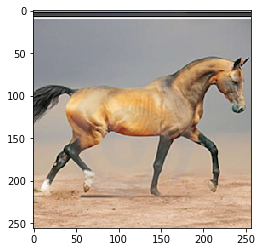

In [21]:
plt.imshow(img, cmap='gray')
plt.show()

In [22]:
import torch
torch.__version__

'1.8.1+cpu'